<a href="https://colab.research.google.com/github/ahassanzadeh/Transaction_Value_Prediction/blob/master/True_amount_cents_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting customer Transactions amount 

How much transaction company should excpect for the next month, quarter and year? 

This questions is categorized under Time series forcasting which is one machine learning branches. they are multiple models for time series forcasting:
- Autoregressive intergrated moving average(ARIMA) -> This model is the generalization of autirefressive moving average(ARMA) model. ARIMA is one most applied method for the time forcasting application in the past. 
- Hidden Markov Modeli(HMM) -> is a statistical model in which the system is assumed to be a Markov process with unobserved(hidden) states. 
- Long short-term memory(LSTM) -> it is one the most recent deep learning approaches make of autoregressive Recurrent Nueral Network(RNN)  

in this approach, LSTM is applied. 

In [0]:
from __future__ import division
from datetime import datetime, timedelta,date
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np


In [0]:
import warnings
warnings.filterwarnings("ignore")

In [0]:
import plotly.plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go

In [0]:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras.layers import LSTM
from sklearn.model_selection import KFold, cross_val_score, train_test_split

Using TensorFlow backend.


In [0]:
from google.colab import files
pyoff.init_notebook_mode()

## Data management 

In [0]:
uploaded = files.upload()


Saving train_val.csv to train_val.csv


In [0]:
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

User uploaded file "train_val.csv" with length 36726232 bytes


In [0]:
df_sales= pd.read_csv("train_val.csv")
# df_sales= pd.read_csv(uploaded)
df_sales.columns=['CustomerID','date', 'sales']

In [0]:
df_sales.shape

(1048575, 3)

In [0]:
df_sales.head(10)

CustomerID  ...    sales
0  54b80cb0cb084b0c00294f2a|6ce908fc9895fdfc035e4...  ...    538.0
1  54bde3073deefe0c00a01401|46e37148a68739387c48b...  ...   1614.0
2  54c6ea8213078c0c001cec71|044a408e374c8a102b709...  ...  22105.0
3  54e643cd95962f0c004cde71|ee74f9800708efd6b39c3...  ...   7803.0
4  54e64674de3f910c0014d567|bac357ccd7c020cf540e8...  ...     25.0
5  54e659bc2fb32c0c007c030f|8816cf3aede474ecbdb03...  ...   2381.0
6  54e67cc651c9f70c00d49a8b|6a9ac4aefba74c038a149...  ...   9990.0
7  54e693f37216210c0042db88|33c26323987617afdcc82...  ...   2500.0
8  54e699308eac6c0c00160cfe|b83c984368bdf9354e147...  ...   6098.0
9  54e69a1d910e5e0c0058bb98|0c978d2645c67c16857d0...  ...    632.0

[10 rows x 3 columns]

In [0]:
df_sales['date'] = df_sales['date']. astype(str).str[:-14]
df_sales['date'] = pd.to_datetime(df_sales['date'], errors='coerce')
# df_sales.sort_values(df_sales['date'], axis=1)

df_sales;

In [0]:
#represent month in date field as its first day
print(df_sales['date'].dt.year.astype('str').str[:4] + '-' + df_sales['date'].dt.month.astype('str') + '-01')
df_sales['date'] = df_sales['date'].dt.year.astype('str') + '-' + df_sales['date'].dt.month.astype('str') + '-01'


0           2018-6.0-01
1          2017-11.0-01
2           2018-4.0-01
3           2018-5.0-01
4          2017-12.0-01
5          2017-10.0-01
6           2018-3.0-01
7           2018-4.0-01
8           2018-6.0-01
9          2017-11.0-01
10          2018-3.0-01
11         2017-12.0-01
12         2017-11.0-01
13         2017-10.0-01
14          2018-1.0-01
15          2018-1.0-01
16         2017-12.0-01
17          2018-6.0-01
18          2018-1.0-01
19          2018-1.0-01
20         2017-10.0-01
21          2018-3.0-01
22          2018-2.0-01
23          2018-3.0-01
24          2018-5.0-01
25          2018-5.0-01
26         2017-10.0-01
27         2017-12.0-01
28          2018-2.0-01
29          2018-4.0-01
               ...     
1048545      nan-nan-01
1048546      nan-nan-01
1048547      nan-nan-01
1048548      nan-nan-01
1048549      nan-nan-01
1048550      nan-nan-01
1048551      nan-nan-01
1048552      nan-nan-01
1048553      nan-nan-01
1048554      nan-nan-01
1048555      nan

In [0]:
#groupby date and sum the sales
df_sales = df_sales.groupby('date').sales.sum().reset_index()

In [0]:
df_sales.head()

date        sales
0  2017.0-10.0-01  481318803.0
1  2017.0-11.0-01  567076518.0
2  2017.0-12.0-01  683587990.0
3   2017.0-9.0-01  107578272.0
4   2018.0-1.0-01  724746118.0

## Stationary/Non-stationary data 

In this sectionm three steps are fllowed data are converted to stationary. 

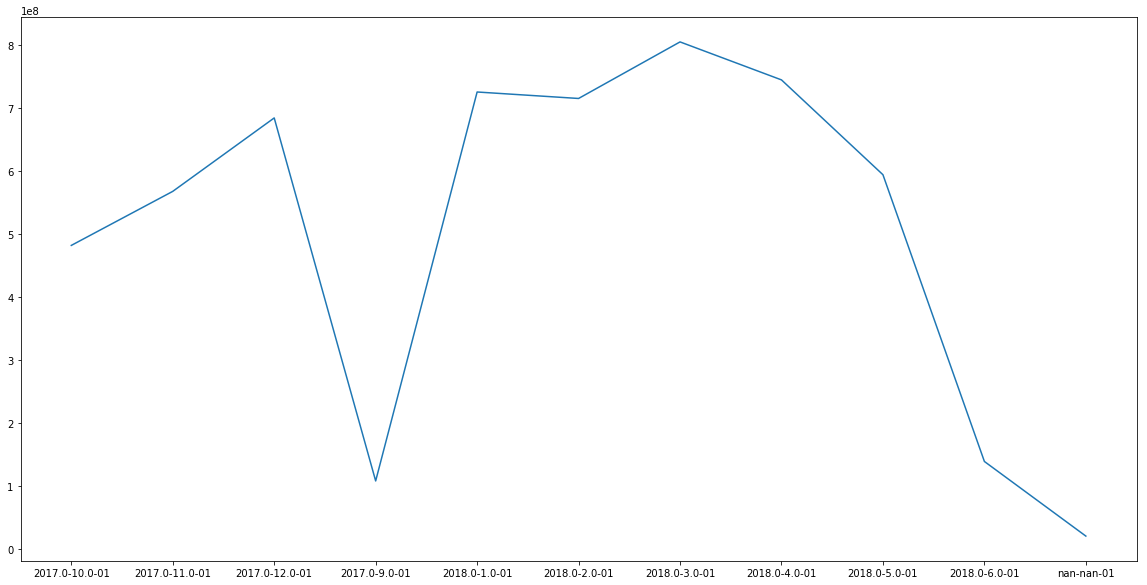

In [0]:
# #plot monthly sales
# plot_data = [
#     go.Scatter(
#         x=df_sales['date'],
#         y=df_sales['sales'],
#     )
# ]

# plot_layout = go.Layout(
#         title='Montly Sales'
#     )
# fig = go.Figure(data=plot_data, layout=plot_layout)
# pyoff.iplot(fig)
import matplotlib.pyplot as plt
x=df_sales['date']
y=df_sales['sales']
plt.figure(figsize=(20,10))
plt.plot(x,y)


Obviously, it is not stationary and has an increasing trend over the months. One method is to get the difference in sales compared to the previous month and build the model on it:



In [0]:
#create a new dataframe to model the difference
df_diff = df_sales.copy()

#add previous sales to the next row
df_diff['prev_sales'] = df_diff['sales'].shift(1)

#drop the null values and calculate the difference
df_diff = df_diff.dropna()
df_diff['diff'] = (df_diff['sales'] - df_diff['prev_sales'])

Now we have the required dataframe for modeling the difference:


In [0]:
df_diff.head(10)

date        sales   prev_sales         diff
1   2017.0-11.0-01  567076518.0  481318803.0   85757715.0
2   2017.0-12.0-01  683587990.0  567076518.0  116511472.0
3    2017.0-9.0-01  107578272.0  683587990.0 -576009718.0
4    2018.0-1.0-01  724746118.0  107578272.0  617167846.0
5    2018.0-2.0-01  714481839.0  724746118.0  -10264279.0
6    2018.0-3.0-01  804230366.0  714481839.0   89748527.0
7    2018.0-4.0-01  743952976.0  804230366.0  -60277390.0
8    2018.0-5.0-01  593491534.0  743952976.0 -150461442.0
9    2018.0-6.0-01  138480480.0  593491534.0 -455011054.0
10      nan-nan-01   20066161.0  138480480.0 -118414319.0

Let’s plot it and check if it is stationary now:

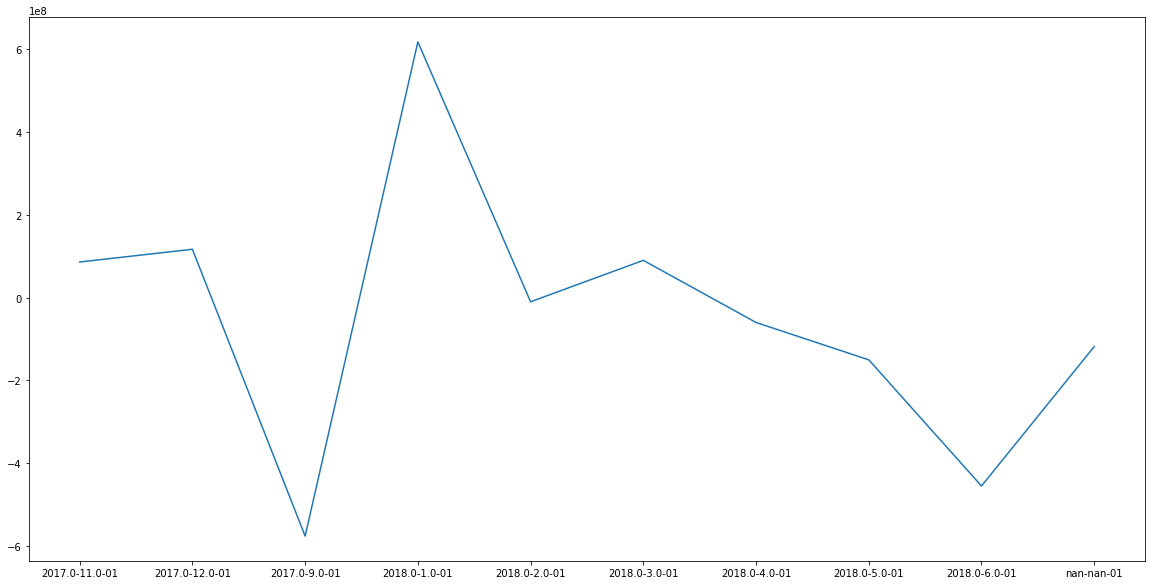

In [0]:
# #plot sales diff
# plot_data = [
#     go.Scatter(
#         x=df_diff['date'],
#         y=df_diff['diff'],
#     )
# ]

# plot_layout = go.Layout(
#         title='Montly Sales Diff'
#     )
# fig = go.Figure(data=plot_data, layout=plot_layout)
# pyoff.iplot(fig)

x=df_diff['date']
y=df_diff['diff']
plt.figure(figsize=(20,10))
plt.plot(x,y)

## Looking at previous monthly data 


In [0]:
#create new dataframe from transformation from time series to supervised
df_supervised = df_diff.drop(['prev_sales'],axis=1)

#adding lags
for inc in range(1,3):
    field_name = 'lag_' + str(inc)
    df_supervised[field_name] = df_supervised['diff'].shift(inc)

Check out our new dataframe called df_supervised:



In [0]:
df_supervised.head(100)

date        sales         diff        lag_1        lag_2
1   2017.0-11.0-01  567076518.0   85757715.0          NaN          NaN
2   2017.0-12.0-01  683587990.0  116511472.0   85757715.0          NaN
3    2017.0-9.0-01  107578272.0 -576009718.0  116511472.0   85757715.0
4    2018.0-1.0-01  724746118.0  617167846.0 -576009718.0  116511472.0
5    2018.0-2.0-01  714481839.0  -10264279.0  617167846.0 -576009718.0
6    2018.0-3.0-01  804230366.0   89748527.0  -10264279.0  617167846.0
7    2018.0-4.0-01  743952976.0  -60277390.0   89748527.0  -10264279.0
8    2018.0-5.0-01  593491534.0 -150461442.0  -60277390.0   89748527.0
9    2018.0-6.0-01  138480480.0 -455011054.0 -150461442.0  -60277390.0
10      nan-nan-01   20066161.0 -118414319.0 -455011054.0 -150461442.0

In [0]:
df_supervised.tail(6)

date        sales         diff        lag_1        lag_2
5   2018.0-2.0-01  714481839.0  -10264279.0  617167846.0 -576009718.0
6   2018.0-3.0-01  804230366.0   89748527.0  -10264279.0  617167846.0
7   2018.0-4.0-01  743952976.0  -60277390.0   89748527.0  -10264279.0
8   2018.0-5.0-01  593491534.0 -150461442.0  -60277390.0   89748527.0
9   2018.0-6.0-01  138480480.0 -455011054.0 -150461442.0  -60277390.0
10     nan-nan-01   20066161.0 -118414319.0 -455011054.0 -150461442.0

In [0]:
#drop null values
df_supervised = df_supervised.dropna().reset_index(drop=True)
df_supervised.head()

date        sales         diff        lag_1        lag_2
0  2017.0-9.0-01  107578272.0 -576009718.0  116511472.0   85757715.0
1  2018.0-1.0-01  724746118.0  617167846.0 -576009718.0  116511472.0
2  2018.0-2.0-01  714481839.0  -10264279.0  617167846.0 -576009718.0
3  2018.0-3.0-01  804230366.0   89748527.0  -10264279.0  617167846.0
4  2018.0-4.0-01  743952976.0  -60277390.0   89748527.0  -10264279.0

In [0]:
# Import statsmodels.formula.api
import statsmodels.formula.api as smf 

# Define the regression formula
model = smf.ols(formula='diff ~ lag_1', data=df_supervised)


# Fit the regression
model_fit = model.fit()

# Extract the adjusted r-squared
regression_adj_rsq = model_fit.rsquared_adj
print(regression_adj_rsq)

-0.010878840961481506


In [0]:
# Import statsmodels.formula.api
import statsmodels.formula.api as smf 

# Define the regression formula
model = smf.ols(formula='diff ~ lag_1 + lag_2 ', data=df_supervised)

# Fit the regression
model_fit = model.fit()

# Extract the adjusted r-squared
regression_adj_rsq = model_fit.rsquared_adj
print(regression_adj_rsq)

-0.21303717997758298


In [0]:
#import MinMaxScaler and create a new dataframe for LSTM model
from sklearn.preprocessing import MinMaxScaler
df_model = df_supervised.drop(['sales','date'],axis=1)

R-squared results is low therefore it shows this regression is not the best method to fit the data as the error is high. however it still applicable to our approach.  

In [0]:
#split train and test set
train_set, test_set = df_model[0:-6].values, df_model[-6:].values

In [0]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 3 columns):
diff     8 non-null float64
lag_1    8 non-null float64
lag_2    8 non-null float64
dtypes: float64(3)
memory usage: 272.0 bytes


In [0]:
#apply Min Max Scaler
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(train_set)
# reshape training set
train_set = train_set.reshape(train_set.shape[0], train_set.shape[1])
train_set_scaled = scaler.transform(train_set)

# reshape test set
test_set = test_set.reshape(test_set.shape[0], test_set.shape[1])
test_set_scaled = scaler.transform(test_set)

## LSTM Model

In [0]:
X_train, y_train = train_set_scaled[:, 1:], train_set_scaled[:, 0:1]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])

In [0]:
X_test, y_test = test_set_scaled[:, 1:], test_set_scaled[:, 0:1]
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [0]:
model = Sequential()
model.add(LSTM(4, batch_input_shape=(1, X_train.shape[1], X_train.shape[2]), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, nb_epoch=500, batch_size=1, verbose=1, shuffle=False)

W0711 07:53:55.671028 139887389857664 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0711 07:53:55.715482 139887389857664 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0711 07:53:55.722385 139887389857664 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0711 07:53:55.985959 139887389857664 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0711 07:53:56.203208 139887389857664 deprecation.py:323

Epoch 1/500
2/2 [==============================] - 4s 2s/step - loss: 1.2773
Epoch 2/500
2/2 [==============================] - 0s 9ms/step - loss: 1.2756
Epoch 3/500
2/2 [==============================] - 0s 9ms/step - loss: 1.2772
Epoch 4/500
2/2 [==============================] - 0s 9ms/step - loss: 1.2775
Epoch 5/500
2/2 [==============================] - 0s 9ms/step - loss: 1.2760
Epoch 6/500
2/2 [==============================] - 0s 9ms/step - loss: 1.2729
Epoch 7/500
2/2 [==============================] - 0s 9ms/step - loss: 1.2689
Epoch 8/500
2/2 [==============================] - 0s 9ms/step - loss: 1.2644
Epoch 9/500
2/2 [==============================] - 0s 8ms/step - loss: 1.2595
Epoch 10/500
2/2 [==============================] - 0s 8ms/step - loss: 1.2544
Epoch 11/500
2/2 [==============================] - 0s 10ms/step - loss: 1.2493
Epoch 12/500
2/2 [==============================] - 0s 10ms/step - loss: 1.2441
Epoch 13/500
2/2 [==============================] - 0s 10ms/

In [0]:
y_pred = model.predict(X_test,batch_size=1)

In [0]:
y_pred

array([[-0.8292972 ],
       [ 0.3131776 ],
       [-0.15181965],
       [-0.34975678],
       [-0.5265635 ],
       [-0.5649002 ]], dtype=float32)

In [0]:
y_test

array([[-0.0516995 ],
       [ 0.11594161],
       [-0.1355313 ],
       [-0.28669749],
       [-0.79718247],
       [-0.23298022]])

In [0]:
#reshape y_pred
y_pred = y_pred.reshape(y_pred.shape[0], 1, y_pred.shape[1])

In [0]:
#rebuild test set for inverse transform
pred_test_set = []
for index in range(0,len(y_pred)):
    print (np.concatenate([y_pred[index],X_test[index]],axis=1))
    pred_test_set.append(np.concatenate([y_pred[index],X_test[index]],axis=1))

[[ -0.82929718   2.44589474 -44.03652611]]
[[ 0.31317759  0.63387185 33.55903817]]
[[-0.15181965  0.92270866 -7.24456999]]
[[-0.34975678  0.48943407 -0.7404667 ]]
[[ -0.52656353   0.22898269 -10.49705787]]
[[ -0.56490022  -0.65055607 -16.3619707 ]]


In [0]:
pred_test_set[0]

array([[ -0.82929718,   2.44589474, -44.03652611]])

In [0]:
#reshape pred_test_set
pred_test_set = np.array(pred_test_set)
pred_test_set = pred_test_set.reshape(pred_test_set.shape[0], pred_test_set.shape[2])

In [0]:
#inverse transform
pred_test_set_inverted = scaler.inverse_transform(pred_test_set)

In [0]:
#create dataframe that shows the predicted sales
result_list = []
sales_dates = list(df_sales[-7:].date)
act_sales = list(df_sales[-7:].sales)
for index in range(0,len(pred_test_set_inverted)):
    result_dict = {}
    result_dict['pred_value'] = int(pred_test_set_inverted[index][0] + act_sales[index])
    result_dict['date'] = sales_dates[index+1]
    result_list.append(result_dict)
df_result = pd.DataFrame(result_list)

In [0]:
df_result

date  pred_value
0  2018.0-2.0-01   250575784
1  2018.0-3.0-01   921899137
2  2018.0-4.0-01   734235532
3  2018.0-5.0-01   555871070
4  2018.0-6.0-01   299928705
5     nan-nan-01  -177953589

In [0]:
df_sales.head()

date        sales
0  2017.0-10.0-01  481318803.0
1  2017.0-11.0-01  567076518.0
2  2017.0-12.0-01  683587990.0
3   2017.0-9.0-01  107578272.0
4   2018.0-1.0-01  724746118.0

In [0]:
#merge with actual sales dataframe
df_sales_pred = pd.merge(df_sales,df_result,on='date',how='left')

In [0]:
df_sales_pred

date        sales   pred_value
0   2017.0-10.0-01  481318803.0          NaN
1   2017.0-11.0-01  567076518.0          NaN
2   2017.0-12.0-01  683587990.0          NaN
3    2017.0-9.0-01  107578272.0          NaN
4    2018.0-1.0-01  724746118.0          NaN
5    2018.0-2.0-01  714481839.0  250575784.0
6    2018.0-3.0-01  804230366.0  921899137.0
7    2018.0-4.0-01  743952976.0  734235532.0
8    2018.0-5.0-01  593491534.0  555871070.0
9    2018.0-6.0-01  138480480.0  299928705.0
10      nan-nan-01   20066161.0 -177953589.0

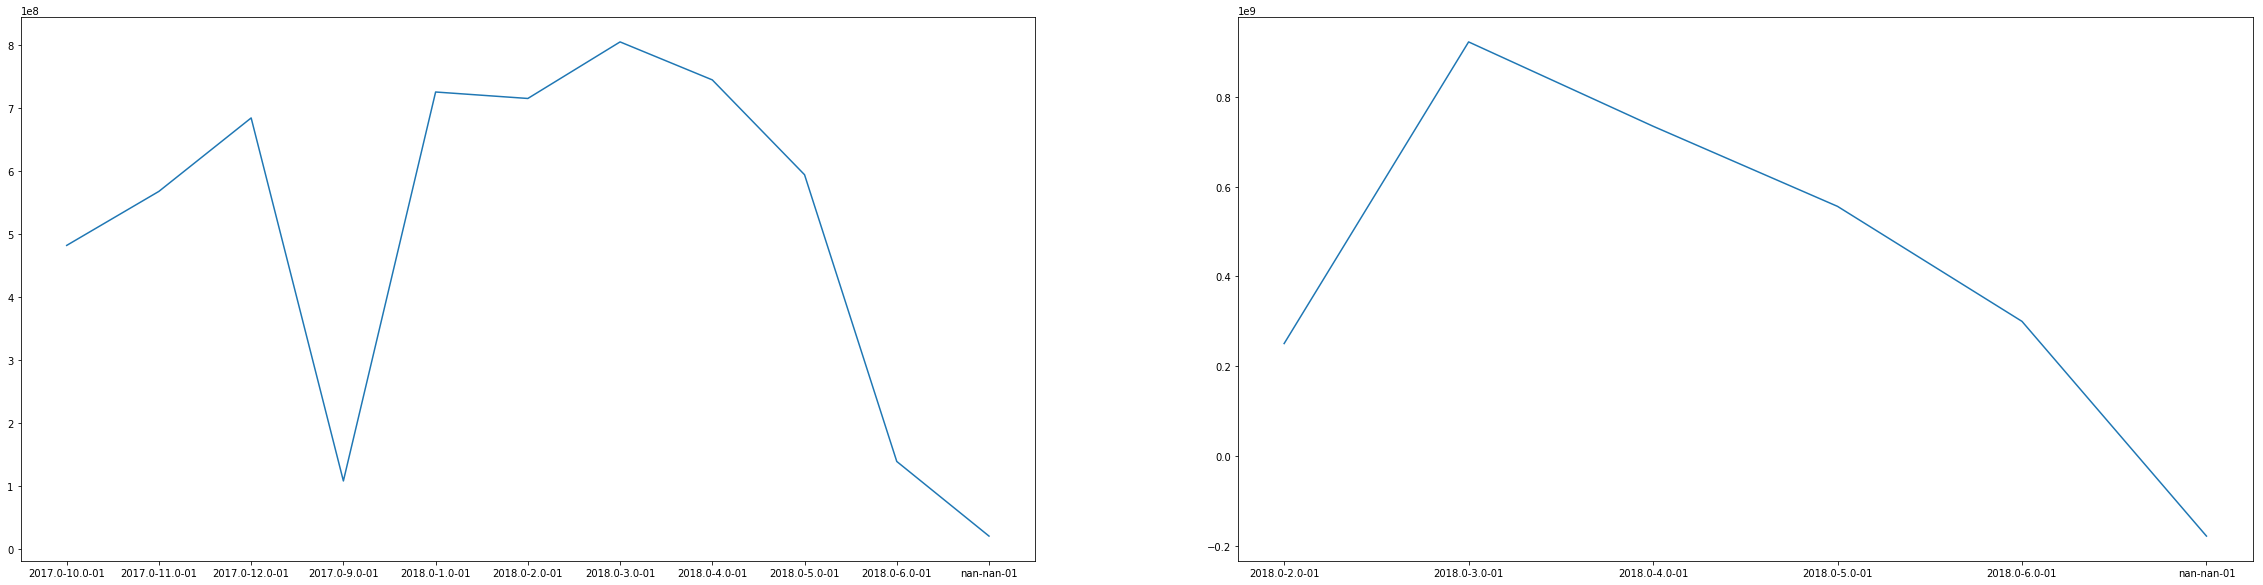

In [0]:
#plot actual and predicted
# plot_data = [
#     go.Scatter(
#         x=df_sales_pred['date'],
#         y=df_sales_pred['sales'],
#         name='actual'
#     ),
#         go.Scatter(
#         x=df_sales_pred['date'],
#         y=df_sales_pred['pred_value'],
#         name='predicted'
#     )
    
# ]

# plot_layout = go.Layout(
#         title='Transaction amount(cents)'
#     )
# fig = go.Figure(data=plot_data, layout=plot_layout)
# pyoff.iplot(fig)

x=df_sales_pred['date']
y=df_sales_pred['sales']
z= df_sales_pred['pred_value']
plt.figure(figsize=(40,10))
grid_size= (1,2)

plt.subplot2grid(grid_size,(0,0))
plt.plot(x,y)

plt.subplot2grid(grid_size,(0,1))
plt.plot(x,z)

plt.show()

The fitting is not ideal and in the future approach other method such a deep nural network should be applied to the problem. Also adding new features to the model can be useful. 
At end, by using this modeli, we have baseline for predictiong the transactions in the future. 